### The notebook shows how to use SLRealzer's own deblend method.

In [1]:
import om10
import desc.slrealizer
import warnings
warnings.filterwarnings("ignore")
import numpy as np

In [2]:
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


In [3]:
db = om10.DB(catalog='../data/qso_mock.fits')
#db.select_random(maglim=23.3,area=18000.0,IQ=0.75)
db.paint(synthetic=True)
realizer = desc.slrealizer.SLRealizer(catalog=db, observation="../data/twinkles_observation_history.csv")

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems


In [4]:
# Choose a good lens system, with large imsep and 4 images:
                      
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

wide_quads = wide[np.where(wide['NIMG'] == 4)]
print "Number of these with 4 images = ",len(wide_quads)

bright_wide_quads = wide[np.where(wide_quads['MAGI'] < 22)]
print "Number of these with i3 < 22 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  10670
Number of these with 4 images =  1559
Number of these with i3 < 22 =  705


OM10: Extracted OM10 lens number 2883888:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
2883888        0    2 0.394 ...         22.05  21.923104371 22.4249882483
('currLens: ', <Table length=1>
 LENSID FLAGTYPE  NIMG  ZLENS  ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
 int32   int16   int16 float64 ...    float64       float64       float64   
------- -------- ----- ------- ... ------------- ------------- -------------
2883888        0     2   0.394 ...         22.05  21.923104371 22.4249882483)
('currObs: ', array([59823.307263999995, 'g', 1.23193, 24.289872], dtype=object))


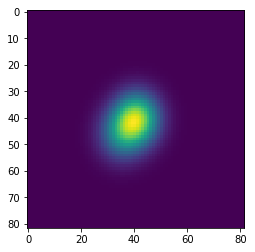

In [5]:
realizer.plot_lens_random_date(lensID=2883888)

OM10: Extracted OM10 lens number 2883888:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
2883888        0    2 0.394 ...         22.05  21.923104371 22.4249882483
('currLens: ', <Table length=1>
 LENSID FLAGTYPE  NIMG  ZLENS  ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
 int32   int16   int16 float64 ...    float64       float64       float64   
------- -------- ----- ------- ... ------------- ------------- -------------
2883888        0     2   0.394 ...         22.05  21.923104371 22.4249882483)
('currObs: ', array([60179.271522, 'i', 1.0252350000000001, 23.348474], dtype=object))


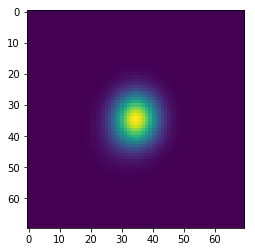

In [7]:
realizer.plot_lens_random_date(lensID=2883888)

OM10: Extracted OM10 lens number 2883888:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
2883888        0    2 0.394 ...         22.05  21.923104371 22.4249882483
('currLens: ', <Table length=1>
 LENSID FLAGTYPE  NIMG  ZLENS  ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
 int32   int16   int16 float64 ...    float64       float64       float64   
------- -------- ----- ------- ... ------------- ------------- -------------
2883888        0     2   0.394 ...         22.05  21.923104371 22.4249882483)
('currObs: ', array([59851.205001, 'u', 1.1784729999999999, 23.02279], dtype=object))


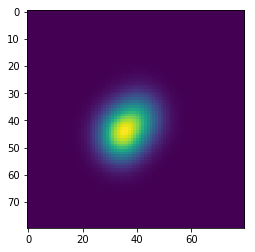

In [10]:
realizer.plot_lens_random_date(lensID=2883888)